In [1]:
#Script per modificare il catalogo GLADE_2.4 cambiandone i valori. 
#------------------Import--------------------------------

import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.optimize import fsolve

from astropy.cosmology import Planck15
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table

from multiprocessing import Pool
import os 
import statistics as stat
import time
from tqdm import tqdm

In [2]:
#Catalogue path
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
#all_event=os.listdir()
#print(all_event)

In [3]:
print(Planck18.H0)

67.66 km / (Mpc s)


In [66]:
H0GLOB= 67#67.9 #69
Om0GLOB=0.319
Xi0Glob =1.
cosmoglob = Planck15
clight = 2.99792458* 10**5#km/s
cosmofast = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
import random as rn
clight = 2.99792458* 10**5#km/s


#---------------Def Funzioni---------------------
def reflag(dataframe, flag_value, trim_factor):
    newdf=dataframe
    print('setting flag error to {} on glaxies, trimming the number by a factor {}'.format(flag_value, trim_factor))
    nrows=int(newdf.shape[0]/trim_factor)
    print('nrows={}, initial rows={}'.format(nrows,newdf.shape[0]))
    if trim_factor!=1:
        newdf=newdf.sample(nrows)
        print('trimmato')
    newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=2,value=flag_value)
    newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=1,value=flag_value)
    if flag_value==4:
        newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=1,value=flag_value)
        newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=2,value=flag_value)
        newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=3,value=flag_value)
        filename=os.path.join(os.getcwd(), 'GLADE_spectro_flag4'+'_'+str(trim_factor)+'.txt')
    else:
        filename=os.path.join(os.getcwd(), 'GLADE_spectro'+'_'+str(trim_factor)+'.txt')
    print('\nsalvataggio del nuovo catalogo, attendere')
    np.savetxt(filename,newdf.values,fmt='%s')
    print('{} salvato'.format(filename))
    
def cont_flag3(dataframe):
    start=dataframe.shape[0]
    flag3=dataframe.apply(lambda x: True if x['lum_dist_flag'] == 3 else False , axis=1)
    nflag=len(flag3[flag3 == True].index)
    perc=nflag*100/start
    print('Initial hosts={}, number of flag3 host={} that is {}%'.format(start,nflag,perc))
    
def cont_flag2(dataframe):
    start=dataframe.shape[0]
    flag2=dataframe.apply(lambda x: True if x['lum_dist_flag'] == 2 else False , axis=1)
    nflag=len(flag2[flag2 == True].index)
    perc=nflag*100/start
    print('Initial hosts={}, number of flag2 host={} that is {}%'.format(start,nflag,perc))
    
def trimmer(dataframe,trim_factor):
    newdf=dataframe
    print('trimming the catalogue by {} %'.format(trim_factor))
    nrows=int(newdf.shape[0]*(1-trim_factor/100))
    print('nrows={}, initial rows={}'.format(nrows,newdf.shape[0]))
    if trim_factor!=0:
        newdf=newdf.sample(nrows)
        print('trimming')
        filename=os.path.join(os.getcwd(), 'GLADE_trimmed'+'_'+str(trim_factor)+'.txt')
        print('\nsalvataggio del nuovo catalogo, attendere')
        np.savetxt(filename,newdf.values,fmt='%s')
        print('{} salvato'.format(filename))
    

def fake_host(df,ra,dec,dl,z):
    newrow=puppetrow
    newrow['right_ascension_degrees']=ra
    newrow['declination_degrees']=dec
    newrow['dl']=dl
    newrow['app_K_mag']=8
    newrow['pec_vel_correction']=1
    #newrow['err_lum_dist']='NaN'
    newrow['z']=z
    return newrow
def random_displace(ra,dec,dl,delta):
    raout=ra+rn.uniform(-1,1)
    decout=dec+rn.uniform(-1,1)
    dlout=rn.gauss(dl,delta)
    zout=Planck15.H(0).value*dlout/clight
    return raout, decout, dlout, zout

def ra_dec_from_th_phi(theta, phi):
        ra = np.rad2deg(phi)
        dec = np.rad2deg(0.5 * np.pi - theta)
        return ra, dec
    
def th_phi_from_ra_dec(ra, dec):
    theta = 0.5 * np.pi - np.deg2rad(dec)
    phi = np.deg2rad(ra)
    return theta, phi

def z_from_dL(dL_val):
    '''
    Returns redshift for a given luminosity distance dL (in Mpc)'''
    
    func = lambda z :cosmofast.luminosity_distance(z).value - dL_val
    z = fsolve(func, 0.77)
    return z[0]

def z_from_dcom(dc_val):
    '''
    Returns redshift for a given comoving distance dc (in Mpc)'''
    
    func = lambda z :cosmofast.comoving_distance(z).value - dc_val
    z = fsolve(func, 0.77)
    return z[0]

In [ ]:
#--------------globals and flags-----------------
nohost=8
clear=1
onebyone=1
#---------------Main-----------------------------
#alcuni appunti sui flag:

#Object type flag: Q the source is from the SDSS-DR12Q catalogue. C: the source is a globular cluster. 
#G:the source is not from the SDSS-DR12Q catalogue and notidentified as a globular cluster

#Luminosity distance measurement flag. 0: the object has neither measured distance nor measured redshift value.
#1: the object has measured redshift value from which we have calculated its distance. 2: the object has measured distance
#value from which we have calculated its redshift. 3: we have replaced the measured photometric redshift with spectroscopic
#redshift from the 2MASS Redshift Survey catalogue,from which we have calculated its distance.

#Velocity correction flag. It indicates whether the peculiar velocity correction was not (’0’) or was (’1’) applied
#when the distance of the object was calculated.

#df = pd.read_csv('TestGLADE.txt', sep=" ", header=None, low_memory=False)
tempdf = pd.read_csv('puppet.txt', sep=" ", header=None, low_memory=False)
df = pd.read_csv('GLADE_2.4.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
df.columns=colnames
tempdf.columns=colnames
puppetrow=tempdf.iloc[0]
ncols=len(df.columns)
nraws=len(df.index)
print("righe={}, colonne={}, shape={} " .format(nraws,ncols,df.shape))

#conteggio eventi tra z1 e z2
#print(df.shape[0])
#z1=0.05
#z2=0.12
#err=0.02
#counterdf=df[df['z'].between(z1-err, z1+err)]
#print(counterdf.shape[0])
#newconter=df[df['z'].between(z2-err, z2+err)]
#print(newconter.shape[0])
#print(len(newconter))


In [ ]:

znull=np.where(df.z.notna(),1,0)
dlnull=np.where(df.dl.notna(),1,0)
z_zero=np.count_nonzero(znull==0)
dl_zero=np.count_nonzero(dlnull==0)
print('la colonna z ha {} elementi nulli\nla colonna dl ha {} elementi nulli'.format(z_zero,dl_zero))
dLvals = df[df.dl.notna()]['dl']
print('%s elementi in dLvals'%dLvals.shape[0])
zvals = df[df.z.notna()]['z']
print('%s elementi in z'%zvals.shape[0])


newdf=df[df['z'].notna()]
newdf=newdf[newdf['dl'].notna()]
znull=np.where(newdf.z.notna(),1,0)
dlnull=np.where(newdf.dl.notna(),1,0)
z_zero=np.count_nonzero(znull==0)
dl_zero=np.count_nonzero(dlnull==0)
col=newdf['z']
max_z=col.max()
print('massimo valore redshift: z={}  '.format(max_z))

print('la colonna z ha {} elementi nulli\nla colonna dl ha {} elementi nulli'.format(z_zero,dl_zero))
#print('\n\n\n salvataggio del nuovo catalogo, attendere')
#np.savetxt('GLADE_nonull.txt',newdf.values,fmt='%s')
#print('GLADE_nonull.txt salvato')
    
    


In [ ]:
#reflag(newdf,3,1)

In [ ]:
#cont_flag3(newdf)

In [ ]:
#cont_flag2(newdf)

In [ ]:
#trimmer(newdf,90)

In [ ]:
#-------------Inserimento Fake Hosts--------------------------
#fake_host(df,ra,dec,dl,z)
iteration=10
#----------------GW190412-----------------------
ra=218.4521484375
dec=36.42357364233115
dl=734.121575455142
std=93.28161482151035
z=0.16587940821823915
toadd=fake_host(newdf,ra,dec,dl,z)
newdf=newdf.append(toadd)
#for i in range(iteration):
    #ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    #toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    #newdf=newdf.append(toadd)
print('1 of 5 done')
#-------------GW190814---------------------------
ra=12.7001953125
dec=-24.87076339473571
dl=240.7344958889034
std=26.05124052395576
z=0.05439548032764159
toadd=fake_host(newdf,ra,dec,dl,z)
newdf=newdf.append(toadd)
#for i in range(iteration):
    #ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    #toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    #newdf=newdf.append(toadd)
print('2 of 5 done')
#---------------GW190924_021846---------------------
ra=127.265625
dec=16.25709623792208
dl=572.3830413569922 
std=136.682093600127
z=0.1293335645605956
toadd=fake_host(newdf,ra,dec,dl,z)
newdf=newdf.append(toadd)
for i in range(iteration):
    ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    newdf=newdf.append(toadd)
print('3 of 5 done')    
#-----------------GW190527_092055--------------------------
ra=39.14383561643836
dec=-63.07261938698223
dl=3562.931275516
std=1965.511983689016
z=0.8050668326134269
toadd=fake_host(newdf,ra,dec,dl,z)
#newdf=newdf.append(toadd)
#for i in range(iteration):
    #ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    #toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    #newdf=newdf.append(toadd)
print('4 of 5 done')

#-----------------GW170817--------------------------
#ra=196.03586373589667 #3.44616 #105.29296875
#dec=-20.841149792255525#-0.408084 #-0.7833651412800737
#dl=34.03408225450563
#std=7.499686641911211
#z=0.0087
#toadd=fake_host(newdf,ra,dec,dl,z)
#newdf=newdf.append(toadd)
#for i in range(iteration):
    #ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    #toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    #newdf=newdf.append(toadd)
print('5 of 5 done')
#------------------Fake-BS-------------------------
ra=196.03586373589667 #3.44616 #105.29296875
dec=-20.841149792255525#-0.408084 #-0.7833651412800737
dl=20
std=4.595980697842096
z=cosmoglob.H(0).value*dl/clight
toadd=fake_host(newdf,ra,dec,dl,z)
newdf=newdf.append(toadd)
newdf=newdf.tail(6)
#----------------Saving-------------------------------
filename=os.path.join(os.getcwd(), 'GLADE_fakeBS20'+'.txt')
print('Saving new catalogue with host injection, wait...')
np.savetxt(filename,newdf.values,fmt='%s')
print('{} saved!'.format(filename))


# From FlagShip to GLADE-like

In [ ]:
#------------read the flagship-------------------------------------
dat = Table.read('11536.fits', format='fits')
flagship = dat.to_pandas()#all good, is an only text fits
print(flagship.columns)
print(flagship.shape[0])
flagship.head(3)

In [ ]:
z=np.array(flagship['true_redshift_gal'])
ra=np.array(flagship['ra_gal'])
dec=np.array(flagship['dec_gal'])
print('z_min={}, z_max={}'.format(np.min(z),np.max(z)))
print('ra_min={}, ra_max={}'.format(np.min(ra),np.max(ra)))
print('dec_min={}, dec_max={}'.format(np.min(dec),np.max(dec)))
thetamin,phimin=th_phi_from_ra_dec(np.min(ra),np.max(dec))
thetamax,phimax=th_phi_from_ra_dec(np.max(ra),np.min(dec))
print('phi_min={}, phi_max={}'.format(phimin,phimax))
print('theta_min={}, theta_max={}'.format(thetamin,thetamax))

In [ ]:
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['ra_gal', 'dec_gal', 'observed_redshift_gal', 'true_redshift_gal',
       'x_gal', 'y_gal', 'z_gal', 'vx_gal', 'vy_gal', 'vz_gal']
randflagship = pd.DataFrame(columns=colnames)
randflagship.head(3)

In [ ]:
randflagship=flagship.head(5000)
cat_name='GLADE_flagship_5000incr.txt'

In [ ]:
#randflagship=randflagship.append(flagship.sample(5500), ignore_index=True)
#randflagship.to_csv('flagrandsource.txt', header=None, index=None, sep=' ')

In [ ]:
#alcuni appunti sui flag:

#Object type flag: Q the source is from the SDSS-DR12Q catalogue.
#C: the source is a globular cluster. 
#G:the source is not from the SDSS-DR12Q catalogue and notidentified as a globular cluster

#Luminosity distance measurement flag.
#0: the object has neither measured distance nor measured redshift value.
#1: the object has measured redshift value from which we have calculated its distance. 
#2: the object has measured distance value from which we have calculated its redshift. 
#3: we have replaced the measured photometric redshift with spectroscopic redshift 
#from the 2MASS Redshift Survey catalogue,from which we have calculated its distance.

#Velocity correction flag. It indicates whether the peculiar velocity correction was not (’0’)
#or was (’1’) applied when the distance of the object was calculated.


In [4]:
#---------------read Glade-------------------
glade = pd.read_csv('GLADE_2.4.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
glade.columns=colnames
glade.head(5)
klum=np.array(glade['app_K_mag'])
#zglade=np.array(flagship['true_redshift_gal'])

In [5]:
mean_app_B_mag=np.sum(glade['app_B_mag'])/glade.shape[0]
mean_abs_B_mag=np.sum(glade['abs_B_mag'])/glade.shape[0]
mean_app_J_mag=np.sum(glade['app_J_mag'])/glade.shape[0]
mean_app_H_mag=np.sum(glade['app_H_mag'])/glade.shape[0]
mean_app_K_mag=np.sum(glade['app_K_mag'])/glade.shape[0]
print(mean_app_B_mag,mean_abs_B_mag,mean_app_J_mag,mean_app_H_mag,mean_app_K_mag)

10.535271935685417 inf 5.277627146516081 4.923685721873297 4.862867403148511


lum mean=13.334410160003385, lum std=0.7488173704298869


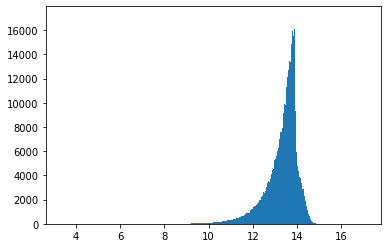

In [6]:
klum = klum[~np.isnan(klum)]
plt.hist(klum,bins='auto')
klum_mean=stat.mean(klum)
klum_std=stat.stdev(klum)
print('lum mean={}, lum std={}'.format(klum_mean,klum_std))

In [7]:
err_app_B_mag=np.sum(glade['err_app_B_mag'])/glade.shape[0]
err_app_J_mag=np.sum(glade['err_app_J_mag'])/glade.shape[0]
err_app_H_mag=np.sum(glade['err_app_H_mag'])/glade.shape[0]
err_app_K_mag=np.sum(glade['err_app_K_mag'])/glade.shape[0]
print(err_app_B_mag,err_app_J_mag,err_app_H_mag,err_app_K_mag)

0.12391253898540787 0.029373865791390466 0.033138621476712704 0.04406159611796981


In [8]:
h=0.67
mynumevent=int(43495)
myngcup=int(4736)
GWGC_name='NGC'+ str(myngcup)
HyperLEDA_name=GWGC_name
MASS_XSC_name='NaN'
type_flag='G'
proxy_row={'numevent':mynumevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':0,'declination_degrees':0,'dl':0,'z':0,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':klum_mean+4,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }

In [ ]:

#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
glade_like = pd.DataFrame(columns=colnames)
#glade_like.columns=colnames
glade_like.head()

In [ ]:
#-----------filler-------------------
def GLADE_inator(iterations):
#for i in tqdm(range(flagship.shape[0])):
#for i in range(iterations):
    i=iterations
    numevent=mynumevent+i
    ngcup=myngcup+i
    GWGC_name='NGC'+ str(ngcup)
    HyperLEDA_name=GWGC_name
    ra_gal=flagship['ra_gal'][i]
    dec_gal=flagship['dec_gal'][i]
    zz=flagship['true_redshift_gal'][i]
    #----------dl----------------------
    #distances are in Mpc/h and are comoving distances. We need luminosity distances and Mpc 
    host_x=flagship['x_gal'][i]/h #restore the right units
    host_y=flagship['y_gal'][i]/h
    host_z=flagship['z_gal'][i]/h

    lum_host_x=host_x*(1+zz)
    lum_host_y=host_y*(1+zz)
    lum_host_z=host_z*(1+zz)
    dl=np.sqrt(lum_host_x**2+lum_host_y**2+lum_host_z**2)
    temp_k_lum=np.random.normal(loc=klum_mean,scale=2*klum_std)
    #----------row to append---------------------
    proxy_row={'numevent':numevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':ra_gal,'declination_degrees':dec_gal,'dl':dl,'z':zz,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':temp_k_lum,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }
    #data.append([proxy_row])
    return proxy_row
    #print(proxy_row)
#glade_like.head()

In [ ]:
arr=np.arange(0,flagship.shape[0],dtype=int)
data=[]
tmp=[]
start_time = time.time()
with Pool(10) as p:
    tmp=p.map(GLADE_inator, arr)
print("--- %s seconds ---" % (time.time() - start_time))
#glade_like.to_csv(r'GLADE_flagship.txt', header=None, index=None, sep=' ', mode='a')

In [ ]:
glade_like=glade_like.append(tmp, ignore_index=True)
glade_like.tail()

In [ ]:
glade_like.to_csv(cat_name, header=None, index=None, sep=' ')

In [ ]:
del tmp
del data

# Cone Selection

In [ ]:
coneflag = pd.read_csv('GLADE_flagship.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
coneflag.columns=colnames

In [ ]:
Sigma_theta=2.2072811544182263 # deg
Sigma_phi=2.2072811544182263 # deg
#Sigma_theta=0.03852432366181943 # rad
#Sigma_phi=0.03852432366181943 # rad

tollerance=2*Sigma_phi
RA05=59.9768875192604
DEC05=60.008985691511455
inf_ra=RA05-tollerance
sup_ra=RA05+tollerance
inf_dec=RA05-tollerance
sup_dec=RA05+tollerance

reduced_flag=coneflag[coneflag['declination_degrees']>inf_dec]
reduced_flag=reduced_flag[reduced_flag['declination_degrees']<sup_dec]
reduced_flag=reduced_flag[reduced_flag['right_ascension_degrees']>inf_ra]
reduced_flag=reduced_flag[reduced_flag['right_ascension_degrees']<sup_ra]
print(coneflag.shape[0],reduced_flag.shape[0],100*reduced_flag.shape[0]/coneflag.shape[0])
#reduced_flag.to_csv('Cone3sig_GW05.txt', header=None, index=None, sep=' ')

In [ ]:
mycone=reduced_flag.head(10)
cat_name='GLADE_flagship_cone05_10incr.txt'
mycone.to_csv(cat_name, header=None, index=None, sep=' ')

# Add host to FlaghShip

In [ ]:
#myglade = pd.read_csv('GLADE_flagship.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
myglade = pd.DataFrame(columns = colnames)
#myglade.columns=colnames
myglade.head(5)

In [ ]:
glade500 = pd.read_csv(cat_name, sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
glade500.columns=colnames

In [ ]:
#GW221007
mynumevent=int(14091027)
myngcup=int(14052268)
GWGC_name='NGC'+ str(myngcup)
HyperLEDA_name=GWGC_name
MASS_XSC_name='NaN'
type_flag='G'
numevent=mynumevent+1
ngcup=myngcup+1
GWGC_name='NGC'+ str(ngcup)
HyperLEDA_name=GWGC_name
ra_gal=22.546875
dec_gal=44.993880150457116
zz=1.7
#----------dl----------------------
dl=13102.8222124438
temp_k_lum=np.random.normal(loc=klum_mean,scale=2*klum_std)
#----------row to append---------------------
proxy_row={'numevent':numevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
       '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
       'right_ascension_degrees':ra_gal,'declination_degrees':dec_gal,'dl':dl,'z':zz,
       'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
       'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
       'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
       'app_K_mag':14,'err_app_K_mag':0,
       'lum_dist_flag':3,'pec_vel_correction':0
      }

In [ ]:
#hostedglade=myglade.append(glade_like, ignore_index=True)
#hostedglade=hostedglade.append(proxy_row, ignore_index=True)
#hostedglade=myglade.append(glade500, ignore_index=True)
hostedglade=glade500.append(proxy_row, ignore_index=True)

In [ ]:
hostedglade=hostedglade.append(proxy_row,ignore_index=True)
hostedglade.tail(10)

In [ ]:
hostedglade.to_csv(cat_name, header=None, index=None, sep=' ')

 # Line of Sight

GW221005 zref=1.4999999

In [ ]:

step=0.15
zref=1.499999
zmin=0.8
inf_range=zref-zmin
inf_Nsteps=inf_range/step
#print(zmin+inf_Nsteps*step)
zmax=2
sup_range=zmax-zref
sup_Nsteps=sup_range/step
#print(zmax-sup_Nsteps*step)
zinf=np.zeros(int(inf_Nsteps))
zsup=np.zeros(int(sup_Nsteps))
for i in range(int(inf_Nsteps)):
    zinf[i]=zref-step*i
zinf=np.sort(zinf)
#print(zinf)
#if zref not in zinf:
#    zinf=np.append(zinf,zref)
for i in range(int(sup_Nsteps)):
    zsup[i]=zref+step*i
#print(zsup)
z_line=np.append(zinf,zsup)
z_line=np.unique(z_line)
print(z_line)

In [ ]:
#myglade = pd.read_csv('GLADE_flagship.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
myglade = pd.DataFrame(columns = colnames)
#myglade.columns=colnames
myglade.head(5)

In [ ]:
#GW221005
offline=2
for i in range(len(z_line)):
    mynumevent=int(14091028)
    myngcup=int(14052269)
    GWGC_name='NGC'+ str(myngcup)
    HyperLEDA_name=GWGC_name
    MASS_XSC_name='NaN'
    type_flag='G'
    numevent=mynumevent+i
    ngcup=myngcup+i
    GWGC_name='NGC'+ str(ngcup)
    HyperLEDA_name=GWGC_name
    ra_fixed=59.9768875192604
    if offline==1:
        if i==0:
            ra_gal=ra_fixed+5
        elif i==len(z_line)-1:
            ra_gal=ra_fixed-5
        else:
            ra_gal=ra_fixed
    elif offline==2:
        if i==0:
            ra_gal=ra_fixed+10
        elif i==1:
            ra_gal=ra_fixed+5
        elif i==len(z_line)-2:
            ra_gal=ra_fixed-5
        elif i==len(z_line)-1:
            ra_gal=ra_fixed-10
        else:
            ra_gal=ra_fixed
    dec_gal=60.008985691511455
    zz=z_line[i]
    #----------dl----------------------
    dl=cosmofast.luminosity_distance(zz).value
    temp_k_lum=np.random.normal(loc=klum_mean,scale=2*klum_std)
    #----------row to append---------------------
    proxy_row={'numevent':numevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':ra_gal,'declination_degrees':dec_gal,'dl':dl,'z':zz,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':14,'err_app_K_mag':0,
           'lum_dist_flag':3,'pec_vel_correction':0
          }
    myglade=myglade.append(proxy_row,ignore_index=True)

In [ ]:
myglade.head(len(z_line))

In [ ]:
myglade.to_csv('GLADE_flagship_lineof05_offline2.txt', header=None, index=None, sep=' ')

In [ ]:
myglade.to_csv('GLADE_flagship_angulardisp05_newsig.txt', header=None, index=None, sep=' ')

# Automatic Host Placer

z_min=0.7887375950813293, z_max=2.0129446983337402
ra_min=1.558116673550103e-05, ra_max=89.99999237060547
dec_min=2.9646462280652486e-06, dec_max=89.98294830322266
phi_min=2.7194266749575036e-07, phi_max=1.5707961320877075
theta_min=0.0002976218846182377, theta_max=1.570796275052059

In [94]:
'''Reading the datasheet of the GWs'''
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)
with open('GW2216xx_datasheet.txt','r') as f:
    next(f)
    lines=f.readlines()
    GWs_dl=[]
    GWs_theta=[]
    GWs_phi=[]
    GWs_z=[]
    for x in lines:
        GWs_dl.append(float(x.split('\t')[1]))
        GWs_theta.append(float(x.split('\t')[2]))
        GWs_phi.append(float(x.split('\t')[3]))
        GWs_z.append(float(x.split('\t')[4]))
    #for i in range(len(GW_z)):
        
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
GWs_dl=np.asarray(GWs_dl)
GWs_theta=np.asarray(GWs_theta)
GWs_phi=np.asarray(GWs_phi)
GWs_z=np.asarray(GWs_z)
#--------------from phi, theta to RA DEC the same way as Maggiore---------------------------
GWs_ra=np.zeros(len(GWs_phi))
GWs_dec=np.zeros(len(GWs_theta))
for j in range(len(GWs_phi)):
    GWs_ra[j]=np.rad2deg(GWs_phi[j])
    GWs_dec[j] = np.rad2deg(0.5 * np.pi - GWs_theta[j])
print(GWs_ra,GWs_dec)

[45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45.
 45. 45.] [45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45.
 45. 45.]


In [42]:
'''New cat containing only the true hosts'''
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
myglade = pd.DataFrame(columns = colnames)
#myglade.columns=colnames
myglade.head(5)

,numevent,GWGC_name,HyperLEDA_name,2MASS_XSC_name,SDSS-DR12Q_name,type_flag,right_ascension_degrees,declination_degrees,dl,err_lum_dist,...,err_app_B_mag,abs_B_mag,app_J_mag,err_app_J_mag,app_H_mag,err_app_H_mag,app_K_mag,err_app_K_mag,lum_dist_flag,pec_vel_correction


In [43]:
for i in range(len(GWs_z)):
    mynumevent=int(90000000)
    myngcup=int(99000000)
    GWGC_name='NGC'+ str(myngcup)
    HyperLEDA_name=GWGC_name
    MASS_XSC_name='NaN'
    type_flag='G'
    numevent=mynumevent+i
    ngcup=myngcup+i
    GWGC_name='NGC'+ str(ngcup)
    HyperLEDA_name=GWGC_name
    ra_gal=GWs_ra[i]
    dec_gal=GWs_dec[i]
    zz=GWs_z[i]
    #----------dl----------------------
    dl=GWs_dl[i]
    temp_k_lum=np.random.normal(loc=klum_mean,scale=2*klum_std)
    #----------row to append---------------------
    proxy_row={'numevent':numevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':ra_gal,'declination_degrees':dec_gal,'dl':dl,'z':zz,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':14,'err_app_K_mag':0,
           'lum_dist_flag':3,'pec_vel_correction':0
          }
    myglade=myglade.append(proxy_row,ignore_index=True)
myglade.tail(len(GWs_z)+10)

,numevent,GWGC_name,HyperLEDA_name,2MASS_XSC_name,SDSS-DR12Q_name,type_flag,right_ascension_degrees,declination_degrees,dl,err_lum_dist,...,err_app_B_mag,abs_B_mag,app_J_mag,err_app_J_mag,app_H_mag,err_app_H_mag,app_K_mag,err_app_K_mag,lum_dist_flag,pec_vel_correction
0,90000000,NGC99000000,NGC99000000,NaN,NaN,G,45.0,45.0,7676.268558,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,14,0,3,0
1,90000001,NGC99000001,NGC99000001,NaN,NaN,G,45.0,45.0,7766.724171,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,14,0,3,0
2,90000002,NGC99000002,NGC99000002,NaN,NaN,G,45.0,45.0,7857.380756,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,14,0,3,0
3,90000003,NGC99000003,NGC99000003,NaN,NaN,G,45.0,45.0,7948.236230,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,14,0,3,0
4,90000004,NGC99000004,NGC99000004,NaN,NaN,G,45.0,45.0,8039.288542,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,14,0,3,0
5,90000005,NGC99000005,NGC99000005,NaN,NaN,G,45.0,45.0,8130.535674,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,14,0,3,0
6,90000006,NGC99000006,NGC99000006,NaN,NaN,G,45.0,45.0,8221.975639,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,14,0,3,0
7,90000007,NGC99000007,NGC99000007,NaN,NaN,G,45.0,45.0,8313.606481,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,14,0,3,0
8,90000008,NGC99000008,NGC99000008,NaN,NaN,G,45.0,45.0,8405.426275,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,14,0,3,0
9,90000009,NGC99000009,NGC99000009,NaN,NaN,G,45.0,45.0,8497.433125,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,14,0,3,0


In [44]:
myglade.to_csv('host_of_GW2216xx.txt', header=None, index=None, sep=' ')

# Uniform distributed in an Octant

https://stackoverflow.com/questions/67285924/random-uniform-3d-distribution-of-points-inside-a-spherical-shell-of-inner-and-o

Also made that in DSIRE. Uniform in DL so then find the z.
dcom_min=2853.24
dcom_max=5345.14

In [72]:
'''Uniform spherical distribution'''
nsamp=int(tmp_flag.shape[0]/2)
print('Half flag={}'.format(nsamp))
nsamp=nsamp+1300000
#nsamp=1000
dcom_min=2853.24
dcom_max=5345.14
z_min=tmp_flag['z'].min()
z_max=tmp_flag['z'].max()
dl_min=cosmofast.luminosity_distance(z_min).value
dl_max=cosmofast.luminosity_distance(z_max).value
phi_min=2.7194266749575036e-07
phi_max=1.5707961320877075
theta_min=0.0002976218846182377
theta_max=1.570796275052059
#------------------points generator------------------
u     = np.random.uniform(0,1,size=nsamp) # uniform random vector of size nsamp
#dl_gals_all     = np.cbrt((u*0**3)+((1-u)*dl_max**3))
dc_gals_all     = np.cbrt((u*0**3)+((1-u)*dcom_max**3))
phi_gals   = np.random.uniform(phi_min,phi_max,nsamp)
theta_gals = np.arccos( np.random.uniform(0,1,nsamp) )
#dl_gals=dl_gals_all[dl_gals_all>=dl_min]
dc_gals=dc_gals_all[dc_gals_all>=dcom_min]
print(len(dc_gals_all),len(dc_gals),len(dc_gals)/len(dc_gals_all))

Half flag=7023766
8323766 7056683 0.8477752738363861


In [73]:
ra_gals=ra = np.rad2deg(phi_gals)
dec_gals = np.rad2deg(0.5 * np.pi - theta_gals)

In [74]:
h=0.67
mynumevent=int(43495)
myngcup=int(4736)
GWGC_name='NGC'+ str(myngcup)
HyperLEDA_name=GWGC_name
MASS_XSC_name='NaN'
type_flag='G'
proxy_row={'numevent':mynumevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':0,'declination_degrees':0,'dl':0,'z':0,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':klum_mean+4,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }

In [75]:
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
glade_like = pd.DataFrame(columns=colnames)
#glade_like.columns=colnames
glade_like.head()

,numevent,GWGC_name,HyperLEDA_name,2MASS_XSC_name,SDSS-DR12Q_name,type_flag,right_ascension_degrees,declination_degrees,dl,err_lum_dist,...,err_app_B_mag,abs_B_mag,app_J_mag,err_app_J_mag,app_H_mag,err_app_H_mag,app_K_mag,err_app_K_mag,lum_dist_flag,pec_vel_correction


In [76]:
#-----------filler-------------------
def GLADE_inator_volume(iterations):
#for i in tqdm(range(flagship.shape[0])):
#for i in range(iterations):
    i=iterations
    numevent=mynumevent+i
    ngcup=myngcup+i
    GWGC_name='NGC'+ str(ngcup)
    HyperLEDA_name=GWGC_name
    ra_gal=ra_gals[i]
    dec_gal=dec_gals[i]
    #dl=dl_gals[i]
    dc=dc_gals[i]
    #----------z----------------------
    #zz=z_from_dL(dl)
    zz=z_from_dcom(dc)
    dl=(1+zz)*dc
    #zz=cosmofast.luminosity_distance(z_min).value
    temp_k_lum=np.random.normal(loc=klum_mean,scale=2*klum_std)
    #----------row to append---------------------
    proxy_row={'numevent':numevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':ra_gal,'declination_degrees':dec_gal,'dl':dl,'z':zz,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':temp_k_lum,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }
    return proxy_row

In [77]:
arr=np.arange(0,len(dc_gals),dtype=int)
data=[]
tmp=[]
start_time = time.time()
with Pool(13) as p:
    tmp=p.map(GLADE_inator_volume, arr)
print("--- %s seconds ---" % (time.time() - start_time))

--- 972.0355310440063 seconds ---


In [80]:
#glade_like=glade_like.append(tmp, ignore_index=True)
glade_like.head()

,numevent,GWGC_name,HyperLEDA_name,2MASS_XSC_name,SDSS-DR12Q_name,type_flag,right_ascension_degrees,declination_degrees,dl,err_lum_dist,...,err_app_B_mag,abs_B_mag,app_J_mag,err_app_J_mag,app_H_mag,err_app_H_mag,app_K_mag,err_app_K_mag,lum_dist_flag,pec_vel_correction
0,43495,NGC4736,NGC4736,NaN,NaN,G,2.864640,32.500890,12796.178416,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,11.151834,0.748817,3,0
1,43496,NGC4737,NGC4737,NaN,NaN,G,10.562633,51.967099,10109.617823,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,11.924271,0.748817,3,0
2,43497,NGC4738,NGC4738,NaN,NaN,G,64.505939,25.638057,8897.715273,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,14.358290,0.748817,3,0
3,43498,NGC4739,NGC4739,NaN,NaN,G,58.814501,56.836542,13079.523267,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,15.078138,0.748817,3,0
4,43499,NGC4740,NGC4740,NaN,NaN,G,81.761149,35.889465,13837.538741,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,13.700204,0.748817,3,0


In [79]:
cat_name='GLADE_flagship_volume_dc.txt'
glade_like.to_csv(cat_name, header=None, index=None, sep=' ')

In [81]:
del tmp
del data
del ra_gals
del dec_gals
del u    
del dc_gals
del phi_gals
del theta_gals

NameError: name 'dl_gals' is not defined

# Append two Cat

In [97]:
tmp_host = pd.read_csv('host_of_GW2216xx.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
tmp_host.columns=colnames

In [98]:
tmp_volume = pd.read_csv('GLADE_flagship_volume_cone16_dc.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
tmp_volume.columns=colnames

In [99]:
tmp_volume=tmp_volume.append(tmp_host, ignore_index=True)
tmp_volume.tail(tmp_host.shape[0]+10)

,numevent,GWGC_name,HyperLEDA_name,2MASS_XSC_name,SDSS-DR12Q_name,type_flag,right_ascension_degrees,declination_degrees,dl,err_lum_dist,...,err_app_B_mag,abs_B_mag,app_J_mag,err_app_J_mag,app_H_mag,err_app_H_mag,app_K_mag,err_app_K_mag,lum_dist_flag,pec_vel_correction
42939,7098101,NGC7059342,NGC7059342,NaN,NaN,G,41.883021,43.810719,15095.620340,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,12.047702,0.748817,3,0
42940,7098745,NGC7059986,NGC7059986,NaN,NaN,G,46.525908,47.404447,11867.653607,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,11.866028,0.748817,3,0
42941,7098999,NGC7060240,NGC7060240,NaN,NaN,G,46.501913,44.160323,14229.520749,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,11.600573,0.748817,3,0
42942,7099119,NGC7060360,NGC7060360,NaN,NaN,G,41.866639,45.636263,10867.965856,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,13.987592,0.748817,3,0
42943,7099123,NGC7060364,NGC7060364,NaN,NaN,G,47.638637,44.735138,5127.133775,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,15.353048,0.748817,3,0
42944,7099331,NGC7060572,NGC7060572,NaN,NaN,G,41.805603,43.500778,13786.597064,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,13.773577,0.748817,3,0
42945,7099591,NGC7060832,NGC7060832,NaN,NaN,G,42.931758,48.069217,14029.348191,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,15.035436,0.748817,3,0
42946,7099597,NGC7060838,NGC7060838,NaN,NaN,G,42.300493,42.672399,11827.207502,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,12.331942,0.748817,3,0
42947,7099986,NGC7061227,NGC7061227,NaN,NaN,G,47.971055,44.383356,14083.496724,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,11.997644,0.748817,3,0
42948,7100015,NGC7061256,NGC7061256,NaN,NaN,G,44.194819,46.071278,11508.245405,NaN,...,0.123913,NaN,5.277627,0.029374,4.923686,0.033139,13.169901,0.748817,3,0


In [100]:
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
tmp_volume.to_csv('GLADE_flagship_cone16_host_dc.txt', header=None, index=None, sep=' ')

# Cone uniform in volume
Sigma_theta=0.019461775056937254, Sigma_phi=0.019461775056937254
Sigma_theta=1.115077572595482°, Sigma_phi=1.115077572595482°

In [92]:
coneflag = pd.read_csv('GLADE_flagship_volume_dc.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
coneflag.columns=colnames

In [93]:
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
appendto = pd.DataFrame(columns = colnames)

In [95]:
Sigma_theta=1.115077572595482 # deg
Sigma_phi=1.115077572595482 # deg
#Sigma_theta=0.03852432366181943 # rad
#Sigma_phi=0.03852432366181943 # rad

tollerance=5*Sigma_phi
#RA=np.rad2deg(np.pi/4)
#DEC=30.0

inf_ra=np.min(GWs_ra)-3*Sigma_phi
sup_ra=np.max(GWs_ra)+3*Sigma_phi
inf_dec=np.min(GWs_dec)-3*Sigma_phi
sup_dec=np.max(GWs_dec)+3*Sigma_phi
print(inf_ra,sup_ra,inf_dec,sup_dec)
reduced_flag=coneflag[coneflag['right_ascension_degrees']>inf_ra]
reduced_flag=reduced_flag[reduced_flag['right_ascension_degrees']<sup_ra]
reduced_flag=reduced_flag[reduced_flag['declination_degrees']>inf_dec]
reduced_flag=reduced_flag[reduced_flag['declination_degrees']<sup_dec]
print(coneflag.shape[0],reduced_flag.shape[0],100*reduced_flag.shape[0]/coneflag.shape[0])

41.654767282213555 48.345232717786445 41.654767282213555 48.345232717786445
7056683 42949 0.6086287282566044


In [96]:
mycone=reduced_flag
cat_name='GLADE_flagship_volume_cone16_dc.txt'
mycone.to_csv(cat_name, header=None, index=None, sep=' ')

# Test

In [49]:
coneflag = pd.read_csv('GLADE_flagship_volume_cone16.txt', sep=" ", header=None, low_memory=False)
#'GLADE_flagship_volume_cone14.txt'

colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
coneflag.columns=colnames

In [58]:
alldl=np.asarray(coneflag['dl'])
Num=10
position=[]
volume=[]
step=(np.max(alldl)-np.min(alldl))/Num
start=np.min(alldl)
for i in range(Num):
    tmp=step/2 + start+(step)*i
    position.append(tmp)
    volume.append(tmp**2)
position=np.asarray(position)
volume=np.asarray(volume)
volume=volume/np.min(volume)
tmp=alldl[alldl<=(start+step)]
norm=len(tmp)
volume=volume*norm

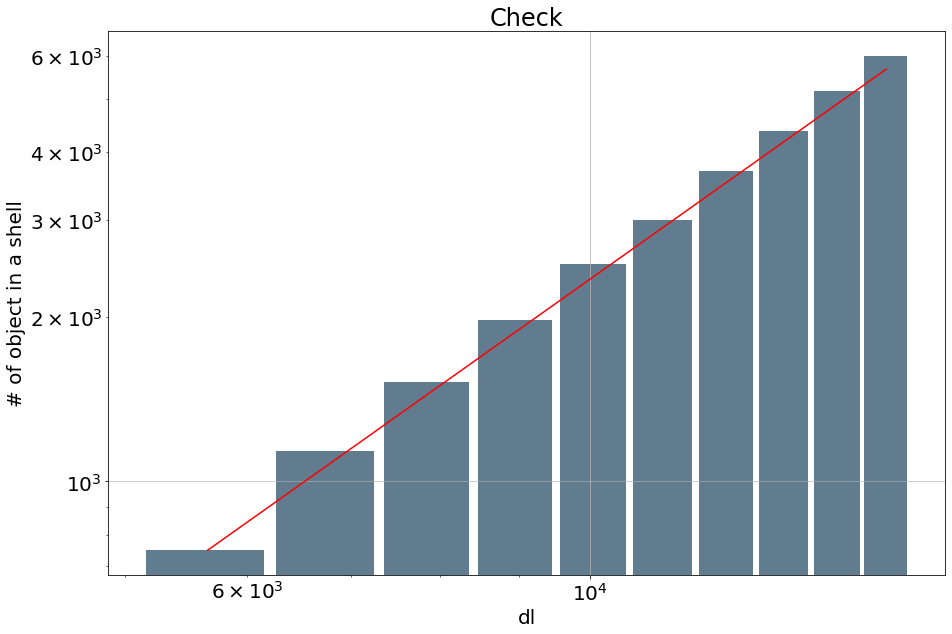

In [59]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,10))
values=coneflag['dl'].hist(grid=True, bins=Num, rwidth=0.9,color='#607c8e')
plt.xscale('log')
plt.yscale('log')
plt.title('Check')

plt.plot(position,volume,color='r')
plt.xlabel('dl')
plt.ylabel('# of object in a shell')
plt.grid(axis='y', alpha=0.75)

In [60]:
position=[]
volume=[]
numobj=[]
#dl_gals
step=(np.max(alldl)-np.min(alldl))/Num
start=np.min(alldl)
for i in range(Num):
    dlsup=step/2 +start+(step)*i
    position.append(dlsup)
    tmp=alldl[alldl<dlsup]
    numobj.append(len(tmp))
    volume.append(dlsup**3-(start)**3)
position=np.asarray(position)
volume=np.asarray(volume)
numobj=np.asarray(numobj)
volume=volume/np.min(volume)
norm=numobj[0]
volume=volume*norm

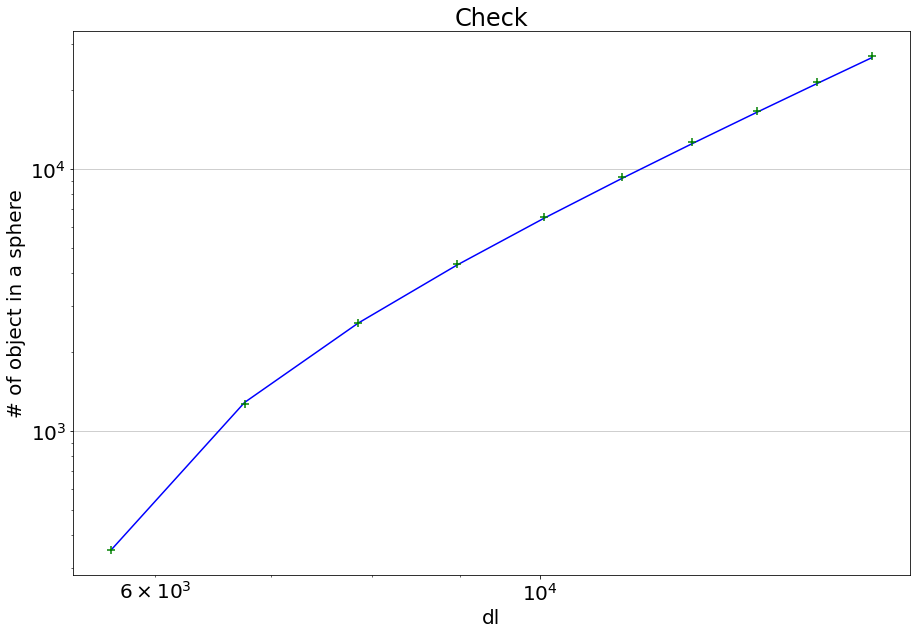

In [61]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,10))
#n, bins, patches = plt.hist(x=numobj,grid=True, bins=Num, rwidth=0.9,color='#607c8e')
plt.xscale('log')
plt.yscale('log')
plt.title('Check')
plt.scatter(position,numobj,s=50, marker='+', c='g', zorder=10 )
plt.plot(position,volume,color='b')
plt.xlabel('dl')
plt.ylabel('# of object in a sphere')
plt.grid(axis='y', alpha=0.75)

In [101]:
nsamp=int(tmp_flag.shape[0]/2)
#nsamp=1000
print(nsamp)
z_min=tmp_flag['z'].min()
z_max=tmp_flag['z'].max()
dl_min=0
dl_max=cosmofast.luminosity_distance(z_max).value
phi_min=2.7194266749575036e-07
phi_max=1.5707961320877075
theta_min=0.0002976218846182377
theta_max=1.570796275052059
#------------------points generator------------------
u     = np.random.uniform(0,1,size=nsamp) # uniform random vector of size nsamp
dl_gals     = np.cbrt((u*dl_max**3)+((1-u)*dl_min**3))
phi_gals   = np.random.uniform(phi_min,phi_max,nsamp)
theta_gals = np.arccos( np.random.uniform(0,1,nsamp) )

7023766


In [ ]:
dl_gals[]